# Predicting bank term deposits: Random Forest vs. Neural Networks
This Python notebook investigates the factors influencing bank term deposit subscriptions using data from a banking institution's direct marketing campaign. Exploiting Random Forest and Neural Network models, the aim is to:


1. Predict the probability of client subscription based on their demographic information, contact details, and previous campaign interactions.
2. Compare model performance using confusion matrices.
3. Uncover the key drivers which influence the subscription decisions for each model.

This analysis will reveal whether the "black-box" nature of these algorithms leads to similar conclusions about which factors most impact term deposit subscriptions.

Feature descriptions:
1. age: Client age
2. job: Client employment
3. marital: Client marital status
4. education: Client education level
5. default: Whether the client has credit in default
6. balance: Client average yearly balance in euros
7. housing: Whether the client has a housing loan
8. loan: Whether the client has a personal loan
9. contact: Client contact type
10. day: Last contact day of the month
11. month: Last contact month of the year
12. duration: Last contact duration in seconds
13. campaign: Number of contacts performed during this campaign and for this client
14. pdays: Number of days since the client was last contacted from a previous campaign
15. previous: Number of contacts performed before this campaign and for this client
16. poutcome: Outcome of the previous marketing campaign
17. y: Client term deposit subscription

### Setup

Import the necessary libraries and modules for the project:

* pandas as pd: Used for data manipulation and analysis.
* MinMaxScaler from sklearn.preprocessing: Scales features to a given range, often between 0 and 1.
* train_test_split from sklearn.model_selection: Splits the dataset into training and testing sets.
* GridSearchCV from sklearn.model_selection: Performs an exhaustive search over specified parameter values for an estimator.
* RandomForestClassifier from sklearn.ensemble: A machine learning algorithm used for classification tasks.
* accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay from sklearn.metrics: Used for evaluating the performance of the classification models.
* Sequential, Dense from tensorflow.keras.models and tensorflow.keras.layers: Used to create and define layers in a neural network.
* matplotlib.pyplot as plt: A plotting library used for visualizing data and results.
These imports provide the tools needed to preprocess the data, build and evaluate the machine learning models (Random Forest and Neural Networks), and visualize the results.

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

Import dataset

In [2]:
df = pd.read_csv('Dataset.csv')

Feature encoding, mapping, and ordering:

* One-hot encoding: The categorical variables 'job', 'marital', 'education', 'contact', and 'poutcome' are one-hot encoded using the pd.get_dummies function. This transformation converts categorical variables into binary vectors, where each category becomes a separate feature.
* Binary encoding: The binary variables 'default', 'housing', 'loan', and the target variable 'y' are encoded as binary values, where 'yes' is mapped to 1 and 'no' is mapped to 0. This step is done using the applymap function along with a lambda function.
* Month mapping: The categorical variable 'month' is numerically mapped to its corresponding integer values using a predefined dictionary month_mapping. This mapping converts month names to numerical values for consistency and ease of processing.
* Consistency conversion: The boolean values 'True' and 'False' are converted to 1 and 0, respectively, for consistency throughout the dataset.
* Reordering features: The features are reordered so that the target variable 'y' is moved to the last column of the DataFrame. This step is done to ensure that the target variable is the last column, which is a common convention in machine learning tasks.

In [3]:
df = pd.get_dummies(df, columns = ['job', 'marital', 'education', 'contact', 'poutcome'])  # One-hot encode features
df[['default', 'housing', 'loan', 'y']] = df[['default', 'housing', 'loan', 'y']].applymap(lambda x: 1 if x == 'yes' else 0)  # Binary encode features

month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
df['month'] = df['month'].map(month_mapping)  # Numerically map feature

df = df.replace(False, 0)  # Convert 'False' to 0 for consistency
df = df.replace(True, 1)  # Convert 'True' to 1 for consistency

df = df[[col for col in df.columns if col != 'y']+ ['y']]  # Reorder features so that y is last

Feature standardisation:

* Standardization: Apply the MinMaxScaler function to the selected numeric columns using the fit_transform method. This scales each numeric feature to a range between 0 and 1, ensuring that all features contribute equally to the model fitting process and preventing any single feature from dominating due to its scale.

In [4]:
numeric_columns = ['age', 'balance', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous']  # Numeric features to be standardised
df[numeric_columns] = MinMaxScaler().fit_transform(df[numeric_columns])  # Standardise features between 0 and 1

Display cleaned dataset

In [5]:
df

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y
0,0.519481,0,0.092259,1,0,0.133333,0.363636,0.053070,0.000000,0.000000,...,1,0,0,0,1,0,0,0,1,0
1,0.337662,0,0.073067,1,0,0.133333,0.363636,0.030704,0.000000,0.000000,...,0,0,0,0,1,0,0,0,1,0
2,0.194805,0,0.072822,1,1,0.133333,0.363636,0.015453,0.000000,0.000000,...,0,0,0,0,1,0,0,0,1,0
3,0.376623,0,0.086476,1,0,0.133333,0.363636,0.018707,0.000000,0.000000,...,0,1,0,0,1,0,0,0,1,0
4,0.194805,0,0.072812,0,0,0.133333,0.363636,0.040260,0.000000,0.000000,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.428571,0,0.080293,0,0,0.533333,0.909091,0.198658,0.032258,0.000000,...,1,0,1,0,0,0,0,0,1,1
45207,0.688312,0,0.088501,0,0,0.533333,0.909091,0.092721,0.016129,0.000000,...,0,0,1,0,0,0,0,0,1,1
45208,0.701299,0,0.124689,0,0,0.533333,0.909091,0.229158,0.064516,0.212156,...,0,0,1,0,0,0,0,1,0,1
45209,0.506494,0,0.078868,0,0,0.533333,0.909091,0.103294,0.048387,0.000000,...,0,0,0,1,0,0,0,0,1,0


### Initialise train and test sets

Prepare the input features x and the target variable y for model training and evaluation:

* Input features: It creates a DataFrame x by dropping the column 'y' from the original DataFrame df using the drop function along the specified axis (axis=1). This ensures that the input features contain all columns except the target variable 'y'.
* Target variable: It creates a Series y containing only the target variable 'y' from the original DataFrame df. This isolates the target variable for use in model training and evaluation.

In [6]:
x = df.drop('y', axis = 1)  # Use all features other than 'y' as model inputs
y = df['y']  # Use 'y' as model output

Split the dataset into training and testing sets using the train_test_split function from the sklearn.model_selection module.

The test_size parameter specifies the proportion of the dataset to include in the testing set (20%), while the random_state parameter ensures reproducibility by fixing the random seed used for the random sampling process.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

### Random Forest

Performs hyperparameter tuning for the Random Forest (RF) classifier using grid search with cross-validation.
* Parameter Grid: It specifies a dictionary param_grid containing the hyperparameters to be tuned. In this case, it focuses on tuning the number of estimators (n_estimators) for the Random Forest classifier, with a range of values [55, 60, 65, 70, 75, 80].
* Random Forest Classifier: It initializes a Random Forest classifier (rf) with a random state set to 42.
* Grid Search: It sets up a GridSearchCV object (grid_search) to perform grid search with cross-validation. It specifies the estimator (rf), parameter grid (param_grid), 5-fold cross-validation (cv=5), and uses all available CPU cores (n_jobs=-1). The verbose=2 parameter controls the verbosity of the output during the grid search process. The scoring metric used is accuracy (scoring='accuracy').
* Fit Grid Search: It fits the grid search to the training data (x_train and y_train) to find the best combination of hyperparameters that maximizes the accuracy score.
* Print Results: It prints out the best parameters (grid_search.best_params_) found by the grid search and the corresponding best cross-validated accuracy score (grid_search.best_score_). This provides insights into the optimal hyperparameter values for the Random Forest classifier based on the training data.

Note that the range of values [55, 60, 65, 70, 75, 80] was found through an iterative approach of narrowing down the possible values.

In [ ]:
'''
param_grid = {
    'n_estimators': [55, 60, 65, 70, 75, 80]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(x_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")
'''

Create and train a Random Forest classifier using the RandomForestClassifier class from the sklearn.ensemble module.

* n_estimators: Specifies the number of decision trees in the forest. Here, n_estimators is set to 70, which means the Random Forest will consist of 70 decision trees.
* random_state: Ensures reproducibility by fixing the random seed used for random number generation during training.

The fit method is then called on the Random Forest classifier (RF) with the training input features (x_train) and training target variable (y_train). This trains the Random Forest model on the training data, allowing it to learn patterns and relationships between the input features and the target variable.

In [ ]:
RF = RandomForestClassifier(n_estimators = 70, random_state = 0)
RF.fit(x_train, y_train)

Makes predictions using the trained Random Forest classifier (RF) on both the training and testing datasets.

* predict_proba: This method predicts the probabilities of the classes for each sample in the input data. [:, 1] selects the probability of the positive class (class 1, which indicates whether the client will subscribe to a term deposit) for each sample in the testing dataset, storing the result in y_pred_prob_rf.
* predict: This method predicts the class labels for each sample in the input data. x_test is used to predict the class labels for the testing dataset, storing the result in y_test_pred_rf. Similarly, x_train is used to predict the class labels for the training dataset, storing the result in y_train_pred_rf.

These predictions will be used for evaluating the performance of the Random Forest classifier on both the training and testing datasets.

In [10]:
y_pred_prob_rf = RF.predict_proba(x_test)[:, 1]
y_test_pred_rf = RF.predict(x_test)
y_train_pred_rf = RF.predict(x_train)

Compute the accuracy scores and generates a classification report for the Random Forest classifier's performance on both the training and testing datasets.

* accuracy_score: This function computes the accuracy of the classifier's predictions by comparing the predicted class labels (y_train_pred_rf and y_test_pred_rf) with the actual class labels (y_train and y_test). The accuracy scores are calculated for both the training and testing datasets.
* classification_report: This function generates a text report showing the main classification metrics (precision, recall, F1-score, and support) for each class in the classification problem. The report is based on comparing the predicted class labels (y_test_pred_rf) with the actual class labels (y_test) for the testing dataset.

The accuracy scores are rounded to four decimal places (train_accuracy_rf and test_accuracy_rf), and the classification report is stored in the variable classification_report_rf for further analysis and interpretation.

In [11]:
train_accuracy_rf = round(accuracy_score(y_train, y_train_pred_rf)*100, 4)
test_accuracy_rf = round(accuracy_score(y_test, y_test_pred_rf)*100, 4)
classification_report_rf = classification_report(y_test, y_test_pred_rf)

### Neural Network

Define and train a neural network (NN) model using the Keras API provided by TensorFlow.

* Model Architecture: The neural network model is defined as a sequential stack of layers. It consists of four dense layers:
  * The first layer (Dense) has 64 units with ReLU activation function and input shape matching the number of features in the training data (x_train.shape[1]).
  * The second layer has 32 units with ReLU activation.
  * The third layer has 16 units with ReLU activation.
  * The final layer has 1 unit with a sigmoid activation function, which is suitable for binary classification tasks.
* Compilation: The model is compiled with the Adam optimizer, binary cross-entropy loss function (suitable for binary classification), and accuracy as the evaluation metric.
* Training: The model is trained using the fit method. It is trained on the training data (x_train and y_train) for 10 epochs with a batch size of 32. Additionally, a validation split of 20% (validation_split=0.2) is used to monitor the model's performance on a validation set during training.

In [ ]:
NN = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

NN.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
NN.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Make predictions using the trained neural network model (NN) on both the training and testing datasets.

* Predictions: The predict method is used to predict the probabilities of the positive class (class 1, indicating whether the client will subscribe to a term deposit) for each sample in the input data (x_test and x_train). The resulting probabilities are stored in y_test_pred_prob_nn and y_train_pred_prob_nn, respectively.
* Thresholding: The predicted probabilities are thresholded at 0.5 to obtain the binary class labels. If the predicted probability is greater than or equal to 0.5, the corresponding class label is set to 1 (indicating subscription to a term deposit); otherwise, it is set to 0 (indicating no subscription). This is achieved using the NumPy astype function. The resulting binary class labels are stored in y_test_pred_nn and y_train_pred_nn, respectively.

In [ ]:
y_test_pred_prob_nn = NN.predict(x_test)
y_test_pred_nn = (y_test_pred_prob_nn >= 0.5).astype(int)

y_train_pred_prob_nn = NN.predict(x_train)
y_train_pred_nn = (y_train_pred_prob_nn >= 0.5).astype(int)

Compute the accuracy scores and generates a classification report for the neural network model's performance on both the training and testing datasets.

* Accuracy Score: The accuracy_score function calculates the accuracy of the model's predictions by comparing the predicted class labels (y_train_pred_nn and y_test_pred_nn) with the actual class labels (y_train and y_test). The resulting accuracy scores are rounded to four decimal places and stored in train_accuracy_nn and test_accuracy_nn for the training and testing datasets, respectively.
* Classification Report: The classification_report function generates a text report showing the main classification metrics (precision, recall, F1-score, and support) for each class in the classification problem. The report is based on comparing the predicted class labels (y_test_pred_nn) with the actual class labels (y_test) for the testing dataset. The generated classification report is stored in the variable classification_report_nn for further analysis and interpretation.

In [14]:
train_accuracy_nn = round(accuracy_score(y_train, y_train_pred_nn)*100, 4)
test_accuracy_nn = round(accuracy_score(y_test, y_test_pred_nn)*100, 4)
classification_report_nn = classification_report(y_test, y_test_pred_nn)

### Compare models

Print out the training and testing accuracies of both the Random Forest (RF) classifier and the neural network (NN) model.

* Training Accuracy: It prints the training accuracy of both models, indicating the percentage of correctly classified samples in the training dataset.
* Testing Accuracy: It prints the testing accuracy of both models, indicating the percentage of correctly classified samples in the testing dataset.

By comparing the training and testing accuracies of both models, we can assess their performance and evaluate if there is any overfitting or underfitting occurring.

In [15]:
print(f"RF training accuracy: {train_accuracy_rf}%")
print(f"RF testing accuracy: {test_accuracy_rf}%")
print()
print(f"NN training accuracy: {train_accuracy_nn}%")
print(f"NN testing accuracy: {test_accuracy_nn}%")

RF training accuracy: 99.9972%
RF testing accuracy: 90.2798%

NN training accuracy: 90.5773%
NN testing accuracy: 89.6052%


Print the classification reports for both the Random Forest (RF) classifier and the neural network (NN) model.

* RF Classification Report: It prints the classification report for the RF classifier, which includes metrics such as precision, recall, F1-score, and support for each class (positive and negative).
* NN Classification Report: It prints the classification report for the NN model, which provides similar metrics as the RF classification report but is based on the predictions of the neural network.

By examining these classification reports, we can gain insights into the performance of each model, including their ability to correctly classify instances of each class and any potential differences in performance between the two models.

In [16]:
print('RF classification report:')
print(classification_report_rf)
print()
print('NN classification report:')
print(classification_report_nn)

RF classification report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7980
           1       0.64      0.39      0.49      1063

    accuracy                           0.90      9043
   macro avg       0.78      0.68      0.72      9043
weighted avg       0.89      0.90      0.89      9043


NN classification report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7980
           1       0.60      0.34      0.44      1063

    accuracy                           0.90      9043
   macro avg       0.76      0.66      0.69      9043
weighted avg       0.88      0.90      0.88      9043



Create a confusion matrix plot for the Random Forest (RF) classifier's predictions on the testing dataset.

* Confusion Matrix Display: It creates a ConfusionMatrixDisplay object using the confusion matrix computed from the actual class labels (y_test) and the predicted class labels (y_test_pred_rf) for the RF classifier's predictions.
* Plotting: It plots the confusion matrix using the plot method of the ConfusionMatrixDisplay object.
* Title: It sets the title of the plot to 'RF Confusion Matrix'.
* Show Plot: It displays the confusion matrix plot using plt.show(). The confusion matrix provides a visual representation of the model's performance by showing the true positive, false positive, true negative, and false negative predictions.

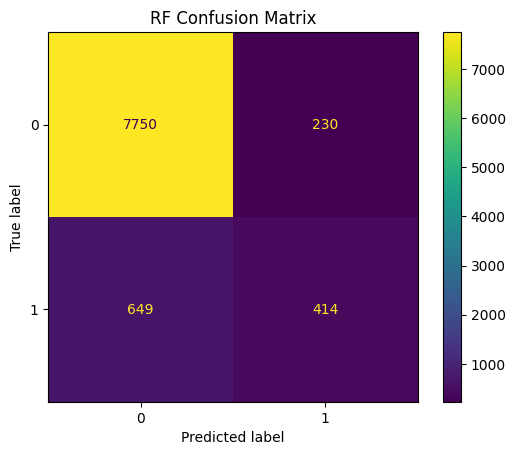

In [17]:
disp_rf = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred_rf))
disp_rf.plot()
plt.title('RF Confusion Matrix')
plt.show()

Create a confusion matrix plot for the neural network (NN) model's predictions on the testing dataset.

* Confusion Matrix Display: It creates a ConfusionMatrixDisplay object using the confusion matrix computed from the actual class labels (y_test) and the predicted class labels (y_test_pred_nn) for the NN model's predictions.
* Plotting: It plots the confusion matrix using the plot method of the ConfusionMatrixDisplay object.
* Title: It sets the title of the plot to 'NN Confusion Matrix'.
* Show Plot: It displays the confusion matrix plot using plt.show(). The confusion matrix provides a visual representation of the model's performance by showing the true positive, false positive, true negative, and false negative predictions.

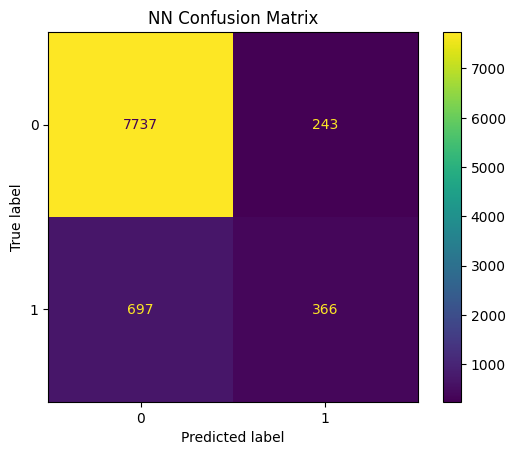

In [18]:
disp_nn = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred_nn))
disp_nn.plot()
plt.title('NN Confusion Matrix')
plt.show()

# Final results, interpretability, and main drivers

Comparing the classification reports of the Random Forest (RF) classifier and the neural network (NN) model reveals differences in their predictive performance, particularly in terms of precision, recall, and F1-score for the positive class (class 1, indicating clients who subscribed to a term deposit).

* Random Forest (RF):
  * Precision for class 1: 0.64
  * Recall for class 1: 0.39
  * F1-score for class 1: 0.49

* Neural Network (NN):
  * Precision for class 1: 0.60
  * Recall for class 1: 0.34
  * F1-score for class 1: 0.44
  
While both algorithms achieve similar accuracy scores (90%) on the testing dataset, they exhibit differences in their ability to correctly classify positive instances (clients who subscribed to a term deposit). The RF classifier generally outperforms the NN model in terms of precision, recall, and F1-score for class 1, indicating that the RF classifier is better at identifying true positive cases (clients who actually subscribed to a term deposit) while minimizing false positives.

Regarding interpretability, the main drivers of decisions in both algorithms can be different due to their inherent differences in modeling techniques. Random Forest, being an ensemble of decision trees, can provide insights into feature importance based on how frequently features are used for splitting in the trees. On the other hand, neural networks, especially deeper architectures, are often considered as black-box models, where the relationships between input features and output predictions are complex and difficult to interpret directly. While techniques such as feature importance analysis or visualization of activation patterns in neural networks exist, they may not offer the same level of interpretability as feature importance in Random Forest models. Therefore, while the RF classifier may provide more transparent insights into the main drivers of its decisions, the NN model's decisions might be less interpretable and may require additional techniques for interpretation.